In [9]:
import pandas as pd
import numpy as np
import talib
import matplotlib.pyplot as plt

class Portfolio:
    def __init__(self, assets, margin):
        self.margin = margin
        self.cash = margin
        self.ticker = assets
        self.assetPosition = {}
        self.tradeHistory = []
        for asset in assets:
            self.assetPosition[asset] = 0

    def buy(self, asset, price, amount):
        cost = price * amount
        if cost <= self.cash:
            self.cash -= cost
            self.assetPosition[asset] += amount
            self.tradeHistory.append(('BUY', asset, price, amount))
        else:
            print("Not enough margin to buy.")

    def sell(self, asset, price, amount):
        if amount <= self.assetPosition[asset]:
            self.cash += price * amount
            self.assetPosition[asset] -= amount
            self.tradeHistory.append(('SELL', asset, price, amount))
        else:
            print("Not enough margin to sell.")

    def get_value(self, market_price):
        value = self.cash
        for asset in self.ticker:
            value += self.assetPosition[asset] * market_price[asset]
        return value


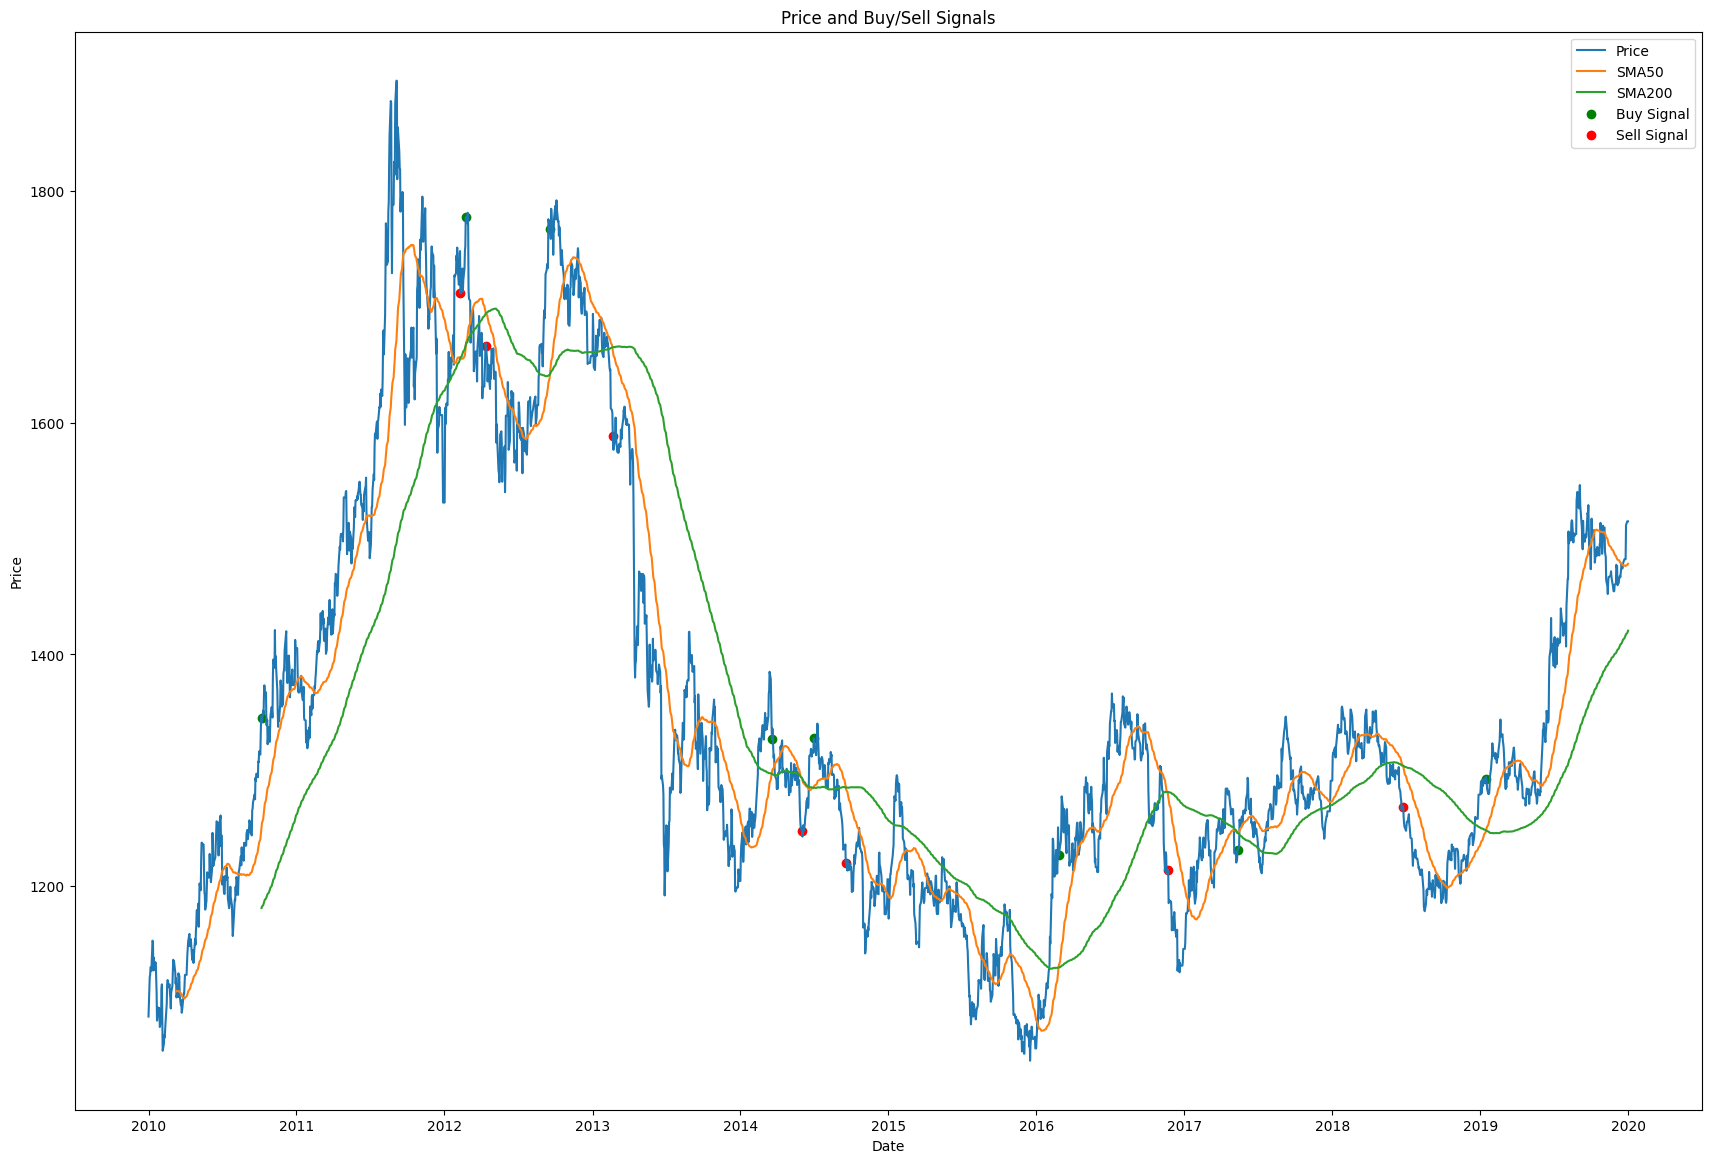

(10000.0, 11061.1, 1061.1000000000004, 0.2086030993159851)

In [10]:
class Backtest:
    def __init__(self, start_date, end_date, initial_cash, input_path):
        self.start_date = pd.to_datetime(start_date)
        self.end_date = pd.to_datetime(end_date)
        self.portfolio = Portfolio(['GOLD'], initial_cash)
        self.data = pd.read_csv(input_path)
        self.data['Date'] = pd.to_datetime(self.data['Date'])
        self.data = self.data[(self.data['Date'] >= self.start_date) & (self.data['Date'] <= self.end_date)]
        self.initial_cash = initial_cash

    def generate_signals(self):
        self.data['Price'] = self.data['Price'].str.replace(',', '').astype('double')
        # Calculate moving averages
        self.data['SMA50'] = talib.SMA(self.data['Price'].values, timeperiod=50)
        self.data['SMA200'] = talib.SMA(self.data['Price'].values, timeperiod=200)
        # Create a signal when the short moving average crosses the long moving average
        self.data['Signal'] = 0
        self.data.loc[self.data['SMA50'] > self.data['SMA200'], 'Signal'] = 1
        self.data['Position'] = self.data['Signal'].diff()

    def execute_trades(self):
        initial_value = self.portfolio.get_value({'GOLD': self.data.iloc[0]['Price']})
        for index, row in self.data.iterrows():
            date = row['Date']
            price = row['Price']
            if row['Position'] == 1:
                # Buy signal
                if self.portfolio.cash >= price:  # Simple condition to check if we have enough cash for at least one unit
                    self.portfolio.buy('GOLD', price, self.portfolio.cash // price)
                else:
                    # Ignore the buy signal if we don't have enough cash
                    continue
            elif row['Position'] == -1:
                # Sell signal
                if self.portfolio.assetPosition['GOLD'] > 0:
                    self.portfolio.sell('GOLD', price, self.portfolio.assetPosition['GOLD'])
        final_value = self.portfolio.get_value({'GOLD': self.data.iloc[-1]['Price']})
        return initial_value, final_value

    def calculate_performance(self, initial_value, final_value):
        pnl = final_value - initial_value
        returns = np.diff(np.log(np.array(self.data['Price'].dropna())))
        sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252)  # Annualized Sharpe Ratio
        return pnl, sharpe_ratio
    
    def plot_results(self):
        fig, ax1 = plt.subplots(figsize=(21, 14))
        ax1.plot(self.data['Date'], self.data['Price'], label='Price')
        ax1.plot(self.data['Date'], self.data['SMA50'], label='SMA50')
        ax1.plot(self.data['Date'], self.data['SMA200'], label='SMA200')
        ax1.scatter(self.data.loc[self.data['Position'] == 1, 'Date'], self.data.loc[self.data['Position'] == 1, 'Price'], color='g', label='Buy Signal')
        ax1.scatter(self.data.loc[self.data['Position'] == -1, 'Date'], self.data.loc[self.data['Position'] == -1, 'Price'], color='r', label='Sell Signal')
        ax1.legend()
        ax1.set_title('Price and Buy/Sell Signals')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Price')
        plt.show()

backtest = Backtest('2010-01-01', '2020-01-01', 10000, './data/gold/Prices_USD.csv')
backtest.generate_signals()
backtest.plot_results()
initial_value, final_value = backtest.execute_trades()
pnl, sharpe_ratio = backtest.calculate_performance(initial_value, final_value)
initial_value, final_value, pnl, sharpe_ratio

In [11]:
print(len(backtest.portfolio.tradeHistory))
backtest.portfolio.tradeHistory


15


[('BUY', 'GOLD', 1345.0, 7.0),
 ('SELL', 'GOLD', 1711.5, 7.0),
 ('BUY', 'GOLD', 1777.5, 7.0),
 ('SELL', 'GOLD', 1666.5, 7.0),
 ('BUY', 'GOLD', 1766.8, 6.0),
 ('SELL', 'GOLD', 1588.5, 6.0),
 ('BUY', 'GOLD', 1327.0, 8.0),
 ('SELL', 'GOLD', 1247.3, 8.0),
 ('BUY', 'GOLD', 1327.5, 7.0),
 ('SELL', 'GOLD', 1219.8, 7.0),
 ('BUY', 'GOLD', 1226.5, 7.0),
 ('SELL', 'GOLD', 1214.3, 7.0),
 ('BUY', 'GOLD', 1231.3, 7.0),
 ('SELL', 'GOLD', 1268.7, 7.0),
 ('BUY', 'GOLD', 1292.3, 7.0)]

In [12]:
backtest.data

,Date,Price,SMA50,SMA200,Signal,Position
8090,2010-01-01,1087.5,NaN,NaN,0,NaN
8091,2010-01-04,1121.5,NaN,NaN,0,0.0
8092,2010-01-05,1123.3,NaN,NaN,0,0.0
8093,2010-01-06,1130.0,NaN,NaN,0,0.0
8094,2010-01-07,1130.3,NaN,NaN,0,0.0
...,...,...,...,...,...,...
10694,2019-12-26,1482.1,1476.284,1416.4570,1,0.0
10695,2019-12-27,1511.5,1476.714,1417.4580,1,0.0
10696,2019-12-30,1514.8,1477.176,1418.4340,1,0.0
10697,2019-12-31,1514.8,1477.764,1419.4265,1,0.0
